In [1]:
# Import program libraries
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
from quantecon.markov.approximation import rouwenhorst

In [2]:
A_size = 5
A_bar = 0
A_sigma = ((1-0.885*0.885)*(0.64**2))**(1/2)
A_rho = 0.95
MrkChain = rouwenhorst(A_size, (1- A_rho) * A_bar, A_sigma, A_rho)
TransMat = MrkChain.P
A_sup = MrkChain.state_values
# print(A_sup)
# print(TransMat)
# print(TransMat.sum(axis=1))
P =1

In [3]:
K_size = 200
K_min = 0.01
K_max = 20
K_vec = np.linspace(K_min, K_max, K_size)
A_vec = np.exp(A_sup)

beta = 0.95
#gamma = 1.0
delta = 0.069
theta = 0.592
#P = 1

Vtp1 = np.zeros((K_size, A_size))
maxiter = 1000
tol_VFI = 1e-12
iter_VFI = 0
dist = 10

A_0_ind = 2
A_0 = A_vec[A_0_ind]
T = 500
S = 100
A_series = np.zeros((T,S))
unif_series = sts.uniform.rvs(size=(T,S))
K_0 = 15

def value_fcn(Vtp1, iter_VFI, dist, gamma, F, P):
    
    while (iter_VFI < maxiter) and (dist >= tol_VFI):
        iter_VFI += 1
    
    # Step 1: take expectation of tomorrow's value function
        Vtp1_flat = Vtp1.T.reshape((1, A_size, K_size))
        Vtp1_big = np.tile(Vtp1_flat, (A_size, 1, 1))
        TransMat_big = np.repeat(TransMat[:, :, np.newaxis], K_size, axis=2)
        EVtp1_a = (TransMat_big * Vtp1_big).sum(axis=1)
        EVtp1_flip = EVtp1_a.reshape((1, A_size, K_size))
        EVtp1 = np.tile(EVtp1_flip, (K_size, 1, 1))
    
    # Step 2: Get all other objects on the right-hand-side of Bellman equation
    # into the shape (K_size, A_size, K_size)
        K_arr = np.tile(K_vec.reshape((K_size, 1, 1)),
                    (1, A_size, K_size))
        Kpr_arr = np.tile(K_vec.reshape((1, 1, K_size)),
                      (K_size, A_size, 1))
        ConvCost = ((gamma / 2) *
                ((((Kpr_arr - (1 - delta) * K_arr) / K_arr)) ** 2) *
                K_arr)
    
        A_arr = np.tile(A_vec.reshape((1, A_size, 1)),
                    (K_size, 1, K_size))
        
        Profits = A_arr * (K_arr ** theta)
        
        InvCost = P* (Kpr_arr - (1 - delta) * K_arr)
        
        LevCost = F * K_arr
    
        V_KAKpr = Profits - ConvCost - InvCost - LevCost + beta * EVtp1
    
    # Step 3: Solve for the K'=psi(K,A) that maximizes using np.argmax
        Psi_ind = V_KAKpr.argmax(axis=2)
        Psi = K_vec[Psi_ind]
    
    # Step 4: Solve for V(K,A)
        V_KA = np.zeros((K_size, A_size))
        for K_ind in range(K_size):
            for A_ind in range(A_size):
                V_KA[K_ind, A_ind] = V_KAKpr[K_ind, A_ind,
                                         Psi_ind[K_ind, A_ind]]

    # Step 5: Check how close V(K,A) is to V'(K,A)
        dist = ((Vtp1 - V_KA).flatten() ** 2).sum()
    #print('Iter=', iter_VFI, ', Dist=', dist)
    
        Vtp1 = V_KA.copy()
    
    V_KA = Vtp1.copy
    
    #for t_ind in range(T):
        #for s_ind in range(S):
            #prob_dist = TransMat[A_0_ind, :]
            #cum_dist = prob_dist.cumsum()
            #unif = unif_series[t_ind, s_ind]
            #A_series[t_ind, s_ind] = A_vec[(unif < cum_dist).argmax()]
            
    #K_series = np.zeros_like(A_series)
    #K_series[0,:] = K_0
    #Psi = value_fcn(gamma, P)
    #for t_ind in range(1, len(K_series)):
        #for s_ind in range(S):
            #A_val = A_series[t_ind - 1, s_ind]
            #A_ind = np.argmin((A_val - A_vec) ** 2)
            #K_val = K_series[t_ind - 1, s_ind]
            #K_ind = np.argmin((K_val - K_vec) ** 2)
            #K_series[t_ind, s_ind] = Psi[K_ind, A_ind]
    
    return Psi

In [4]:
A_0_ind = 2
A_0 = A_vec[A_0_ind]
T = 500
S = 5
A_series = np.zeros((T,S))
unif_series = sts.uniform.rvs(size=(T,S))
for t_ind in range(T):
    for s_ind in range(S):
        prob_dist = TransMat[A_0_ind, :]
        cum_dist = prob_dist.cumsum()
        unif = unif_series[t_ind, s_ind]
        A_series[t_ind, s_ind] = A_vec[(unif < cum_dist).argmax()]

#A_series
#plt.plot(np.arange(1, T + 1), A_series)
#plt.show()

In [5]:
K_0 = 15
def psi(Vtp1, iter_VFI, dist, unif_series, gamma,F,P):
    K_series = np.zeros_like(A_series)
    K_series[0,:] = K_0
    Psi = value_fcn(Vtp1, iter_VFI, dist, gamma,F,P)
    for t_ind in range(1, len(K_series)):
        for s_ind in range(S):
            A_val = A_series[t_ind - 1, s_ind]
            A_ind = np.argmin((A_val - A_vec) ** 2)
            K_val = K_series[t_ind - 1, s_ind]
            K_ind = np.argmin((K_val - K_vec) ** 2)
            K_series[t_ind, s_ind] = Psi[K_ind, A_ind]
            
    return K_series
        
#print(K_series.shape)
#plt.plot(K_series[:,0])
#plt.show()

In [6]:
data_mom1 = 0.058
data_mom2 = 0.143
data_mom3 = 0.186
data_mom4 = 0.018
moms_data = np.array([data_mom1, data_mom2, data_mom3, data_mom4])
#K = K_series[0:499,:]
#Kpr = K_series[1:500,:]
#I = Kpr - (1-delta) * K
#i = I / K
#print(i.shape)

#mom3 = (i >= 0.2).sum(axis=0) / i.shape[0]
#print(mom3.shape)

def sim_moments(Vtp1, iter_VFI, dist, unif_series, gamma,F,P):
    K_series = psi(Vtp1, iter_VFI, dist, unif_series, gamma,F,P)
    K = K_series[0:499,:]
    Kpr = K_series[1:500,:]
    I = Kpr - (1-delta) * K
    i = I / K
    a = np.log(A_series)
#bbb = i[0:498,1]
#ccc = i[1:499,1]
#print('bbbshape=', bbb.shape)
#print('cccshape=', ccc.shape)
#print(I.shape)
#print('ishape=', i.shape)

    mom1 = np.zeros((1,S))

#print(mom1.shape)
#cov1 = np.corrcoef(i[0:498,1], i[1:499,1])
#print(cov1.shape)
    mom2 = np.zeros((1,S))
#mom3 = np.zeros((1,S))
#mom4 = np.zeros((1,S))
    for s in range(S):
        cov1 = np.corrcoef(i[0:498,s], i[1:499,s])
        cov2 = np.corrcoef(i[0:499,s], a[0:499,s])
        mom1[:,s] = cov1[0,1]
        mom2[:,s] = cov2[0,1]
    #mom3[s] = i[(i >= 0.2), s].shape[0] / i[:,s].shape[0]
    #mom4[s] = i[(i <= -0.2), s].shape[0] / i[:,s].shape[0]
    mom3 = (i >= 0.2).sum(axis=0) / i.shape[0]
    mom4 = (i <= -0.2).sum(axis=0) / i.shape[0]
    return mom1, mom2, mom3, mom4
    #mom1, mom2, mom3, mom4 = sim_moments(unif_series)
#print(I.shape)
#bpct_4_dat = xvals[xvals >= 430].shape[0] / xvals.shape[0]
#mom3 = (i <= -0.2).sum() / i.shape[0]
#print(mom3)

In [7]:
# Create the error vector
def err_vec(Vtp1, iter_VFI, dist, unif_series, gamma, F,P):
    sim_mom1, sim_mom2, sim_mom3, sim_mom4 = sim_moments(Vtp1, iter_VFI, dist, 
                                                         unif_series, gamma, F,P)
    mod_mom1 = sim_mom1.mean()
    mod_mom2 = sim_mom2.mean()
    mod_mom3 = sim_mom3.mean()
    mod_mom4 = sim_mom4.mean()
    moms_model = np.array([mod_mom1, mod_mom2, mod_mom3, mod_mom4])
    err_vec = (moms_model - moms_data)/moms_data
    return err_vec

# Create the ctiterion function
def crit(params, *args):
    gamma,F = params
    unif_series, W = args
    err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma, F,P)
    crit_val = err @ W @ err.T
    return crit_val

In [13]:
# Set the initial values and bounds of the parameters and the weighted matrix
gamma_init = 0.275
F_init = 0.1
#P_init = 1
params_init = np.array([gamma_init, F_init])
bounds = ((1e-10, 10),(1e-10, 1))
W = np.eye(4)

# Conduct SMM
smm_arg = (unif_series, W)
result = opt.minimize(crit, params_init, args=(smm_arg), bounds = bounds, options={'eps': 1.0})
gamma_smm1, F_smm1= result.x
print(result)
#err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma_smm1, P_smm1)
#print(err)

      fun: 23.719648720644773
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.61581502, 27.76121682])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 78
      nit: 1
   status: 2
  success: False
        x: array([0.35276252, 0.04783348])


In [10]:
err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma_smm1, F_smm1, P)
print(err*moms_data+moms_data)

[-0.13779309  0.58479411  0.09258517  0.04809619]


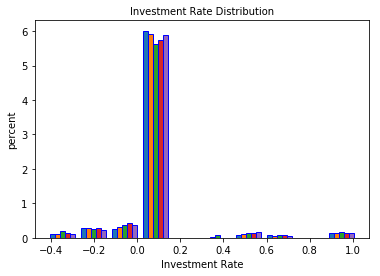

In [19]:
K_series = psi(Vtp1, iter_VFI, dist, unif_series, gamma_smm1,F_smm1,P)
K = K_series[0:499,:]
Kpr = K_series[1:500,:]
I = Kpr - (1-delta) * K
i = I / K
count, bins, ignored = plt.hist(i[:,:], 10, edgecolor='blue', normed=True)
plt.title('Investment Rate Distribution', fontsize=10)
plt.xlabel('Investment Rate')
plt.ylabel('percent')
plt.show()

In [ ]:
# Compute the two-step estimator.
err = err_vec(Vtp1, iter_VFI, dist, unif_series, gamma_smm1, P_smm1)
err_1 = err.reshape(1,4)
#print(err_1)

omega = (err_1.T @ err_1) 
#/ moms_data.shape[0]
#print(omega)
W_2_step = np.linalg.pinv(omega)
#print(W_2_step)


In [ ]:
# Estimate the parameters using the two-step estimator.
params_init = np.array([gamma_smm1, P_smm1])
result = opt.minimize(crit, params_init, args = (unif_series, W_2_step), bounds = bounds, options={'eps': 1.0})
gamma_smm2, P_smm2 = result.x
print(result)

In [ ]:
xx = np.array([1,3,5,7,9])
yy = xx[[1,2]]
print(yy)

In [ ]:
print(Psi.shape)
print(Psi)

In [ ]:
print(A_series.shape)
print(unif_series.shape)
print(A_vec.shape)
print(A_vec.T)

In [ ]:
print(Psi_ind)

In [ ]:
print(prob_dist)

In [ ]:
# Compute the two-step estimator.
#omega = (err.T @ err) / data1.shape[0] #data1=number of observations(simulations) or =1? since we only have
#data moments
W_2_step = np.linalg.pinv(omega)

# Estimate the parameters using the two-step estimator.
params_init = np.array([gamma_smm1, P_smm1])
result = opt.minimize(crit, params_init, args = (unif_series, W_2_step), bounds = bounds)
gamma_smm2, P_smm2 = result.x
print(result)